In [10]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from sklearn import preprocessing
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
import glob
import tensorflow as tf
import imgaug as ia
from imgaug import augmenters as iaa
from collections import Counter
%matplotlib inline

## Load Images

In [11]:
images = []
files = []
names = []
for filename in glob.glob('input/images-train/*/*.jpg'): 
    im=Image.open(filename)
    images.append(im)
    files.append(filename)
    names.append(filename.split('/')[2])
    
files = np.array(files)
names = np.array(names)

### Statistics

Total files: 5211
Total celeberties: 98


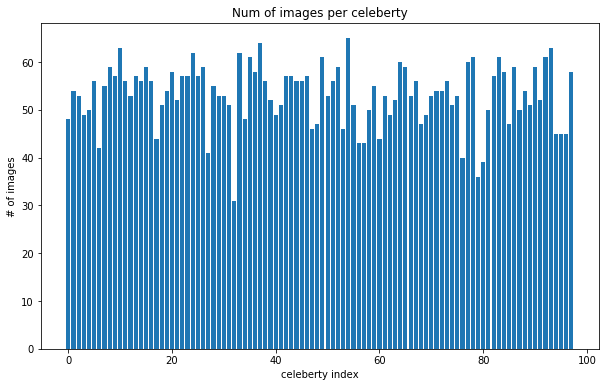

In [12]:
count = Counter(names)
print(f'Total files: {len(filenames)}')
print(f'Total celeberties: {len(count)}')

plt.figure(figsize=(10, 6))

plt.bar(range(len(count)), list(count.values())[::-1], align='center')
plt.title("Num of images per celeberty")
plt.xlabel('celeberty index')
plt.ylabel('# of images')

plt.show()

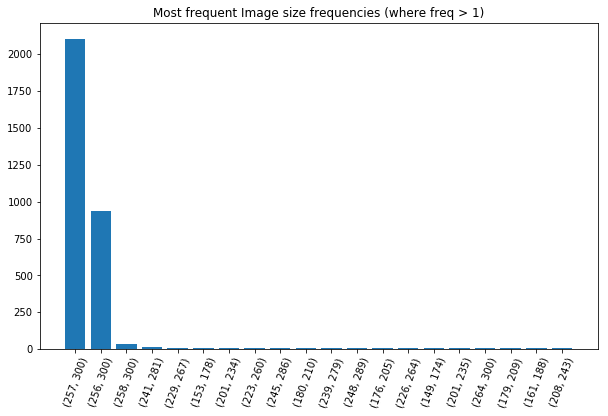

In [13]:
img_sizes = Counter([i.size for i in images])

size, freq = zip(*Counter({i: v for i, v in img_sizes.items() if v > 1}).most_common(20))

plt.figure(figsize=(10, 6))

plt.bar(range(len(freq)), list(freq), align='center')
plt.xticks(range(len(size)), list(size), rotation=70)
plt.title("Most frequent Image size frequencies (where freq > 1)")

plt.show()

### Look at a sample

adam_levine


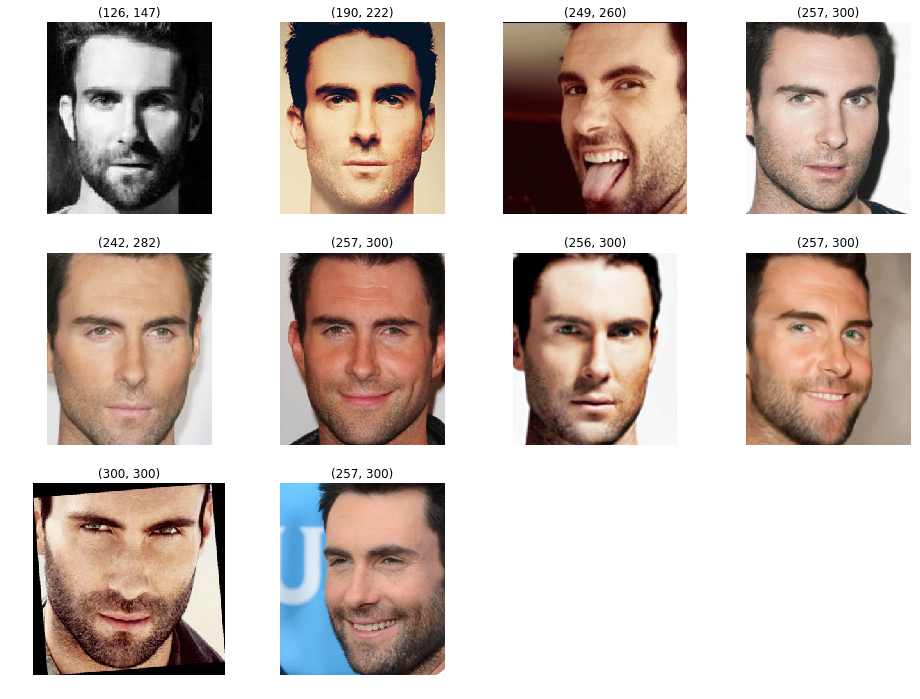

In [14]:
figure = plt.figure(figsize=(16, 12))

rows = 3
cols = 4
cols = len(images[:10]) // rows +1

for i in range(len(images[:10])):
    subplot = figure.add_subplot(rows, cols, i+1)
    subplot.axis('Off')
    subplot.set_title(images[i].size, fontsize=12)
    plt.imshow(images[i], cmap='gray')
print(names[9])

## Processing

### Pad to same size

In [15]:
def pad2sqr(im, desired_size = 300):
    old_size = im.size  # old_size[0] is in (width, height) format
    ratio = float(desired_size)/max(old_size)
    
    new_size = tuple([int(x*ratio) for x in old_size])
    # use thumbnail() or resize() method to resize the input image
    # thumbnail is a in-place operation
    # im.thumbnail(new_size, Image.ANTIALIAS)

    im = im.resize(new_size, Image.ANTIALIAS)
    # create a new image and paste the resized on it

    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(im, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))

    return new_im

In [17]:
for i in range(len(images)):
    padded = pad2sqr(images[i], 300)
    images[i] = padded
images = np.stack(images)
print(images.shape)

(5211, 300, 300, 3)


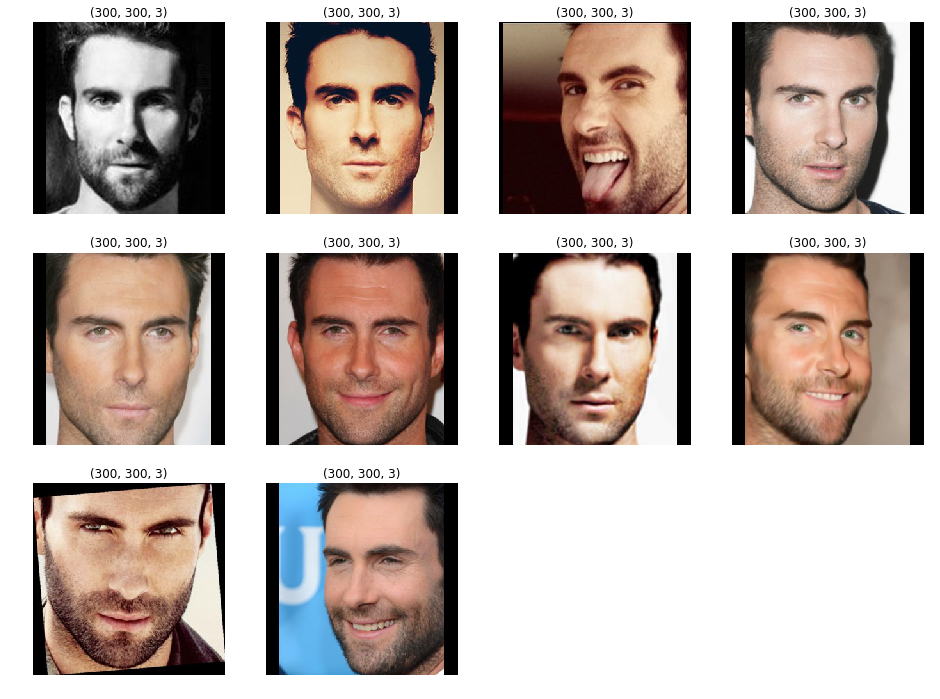

In [18]:
figure = plt.figure(figsize=(16, 12))

rows = 3
cols = 4
cols = len(images[:10]) // rows +1

for i in range(len(images[:10])):
    subplot = figure.add_subplot(rows, cols, i+1)
    subplot.axis('Off')
    subplot.set_title(images[i].shape, fontsize=12)
    plt.imshow(images[i], cmap='gray')


### Label encoding

In [ ]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
names = to_categorical(names, num_classes = 98)

### Split training and valdiation set

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index  = list(sss.split(images, names))[0]
X_train = images[train_index]
Y_train = names[train_index]
X_test = images[test_index]
Y_test = names[test_index]

### Augmentation

### Normalization